# A/B Testing with Chi-Squared Test
```
A/B-тестирование для показателей кликабельности на основе датасета сервиса Keggle.  
Этот набор данных содержит результат A/B-тестирования, в ходе которого две группы людей просмотрели старую веб-страницу и новую веб-страницу. Целью этого теста было определить, привели ли изменения новой веб-страницы к значительному
увеличению числа конверсий по сравнению со старой.  
```

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

**Словарь данных:**  
 - `user_id` - код посетителя сайта (уникальный)
 - `timestamp` - время посещения сайта
 - `group` - группа посетителей
 - `landing_page` - веб-страница
 - `converted` - перешедшие пользователи

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Проверка данных на чистоту  
   
Каждая строка выбранного датасета представляет уникального пользователя и показывает, принадлежат ли они к контрольной (`control`) или экспериментальной группе (`treatment`), а также конвертировались они или нет.  

**Контрольная группа просматривала старую страницу, экспериментальная новую**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

  
Около 2000 человек контрольной группы видели новую страницу веб-сайта, примерно столько же людей экспериментальной группы видели старую страницу. Данные пользователи являются *ошибочными* и для чистоты анализа их необходимо удалить. 

In [6]:
df_cleaned = df.loc[(df['group'] == 'control')&(df['landing_page'] == 'old_page'
                                               ) | (df['group'] == 'treatment')&(df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [7]:
 df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


Теперь необходимо проверить данные на дубликаты.

In [8]:
df_cleaned['user_id'].duplicated().sum()

1

In [9]:
dublicates = df_cleaned['user_id'].duplicated()
df_cleaned[dublicates]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [10]:
 df_cleaned[df_cleaned['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep="first")
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


### Анализ данных      
Рассмотрим распределение конверсии пользователей по группам.

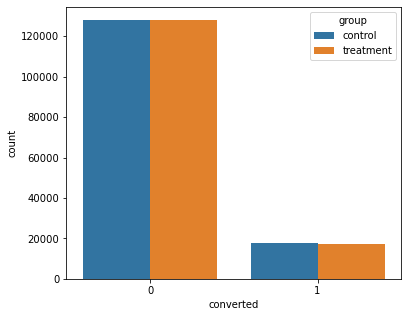

In [12]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.countplot(x = 'converted', data = df_cleaned, hue = 'group')
plt.show()

На первый взгляд доля конверсии одинаковая для обеих групп.  
Рассчитаем соотношение посетителей по страницам.

In [13]:
df_cleaned[df_cleaned['landing_page'] == 'old_page'].value_counts()

user_id  timestamp                   group    landing_page  converted
630002   2017-01-19 19:20:56.438330  control  old_page      0            1
841104   2017-01-15 06:01:46.792793  control  old_page      0            1
841089   2017-01-08 20:01:07.481530  control  old_page      0            1
841090   2017-01-14 21:58:43.475916  control  old_page      1            1
841093   2017-01-17 02:03:27.903125  control  old_page      0            1
                                                                        ..
735700   2017-01-21 23:26:33.722148  control  old_page      0            1
735697   2017-01-21 22:22:35.687498  control  old_page      0            1
735696   2017-01-04 00:44:37.721582  control  old_page      0            1
735695   2017-01-11 12:13:00.245379  control  old_page      0            1
945998   2017-01-16 07:08:02.207969  control  old_page      0            1
Length: 145274, dtype: int64

In [14]:
df_cleaned[df_cleaned['landing_page'] == 'new_page'].value_counts()

user_id  timestamp                   group      landing_page  converted
630000   2017-01-19 06:26:06.548941  treatment  new_page      0            1
840313   2017-01-02 19:23:46.139371  treatment  new_page      0            1
840300   2017-01-14 01:56:49.176187  treatment  new_page      0            1
840302   2017-01-09 17:54:02.034139  treatment  new_page      0            1
840306   2017-01-11 04:02:28.271160  treatment  new_page      0            1
                                                                          ..
734911   2017-01-22 17:27:20.964901  treatment  new_page      0            1
734910   2017-01-09 10:39:23.462637  treatment  new_page      0            1
734909   2017-01-09 19:40:14.916799  treatment  new_page      1            1
734901   2017-01-07 01:52:02.329270  treatment  new_page      1            1
945999   2017-01-16 04:56:21.132067  treatment  new_page      0            1
Length: 145310, dtype: int64

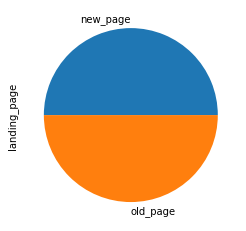

In [15]:
df_cleaned['landing_page'].value_counts().plot.pie();

Соотношение людей, посетивших старую и новую страницу практически одинаково.

### Cтатистический анализ хи-квадрат
Нулевой гипотезой данного исследования является идея о том, что между частотами переходов на старую и новую страницы нет разницы, и они одианковы.  
Критерий хи-квадрат сравнивает наблюдаемые и ожидаемые частоты в каждой категории, чтобы проверить, что либо все категории содержат одинаковые доли значений, либо каждая категория содержит заданную долю значений.

In [16]:
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']

a_click = a.converted.sum()
a_noclick = a.converted.size - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()

T = np.array([[a_click, a_noclick], [b_click, b_noclick]])
T

array([[ 17489, 127785],
       [ 17264, 128046]], dtype=int64)

In [17]:
from scipy.stats import chi2_contingency
print('p = ', chi2_contingency(T)[1])

p =  0.1918222809623566


Расчетное значение p равно **19%**. Предполагая уровень значимости 5%, мы можем сделать вывод, что мы *не отвергаем нулевую гипотезу*. Проще говоря, конверсии между старой и новой веб-страницей не имеют значения.

In [18]:
a_test = a_click / (a_click + a_noclick)
b_test = b_click / (b_click + b_noclick)
print(a_test, b_test)

0.1203863045004612 0.11880806551510564


Проверка в виде расчета отношения перешедших по старой и новой странице практически одинаковые, следовательно,   
**вывод о верности нулевой гипотезы верен.**